In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from tigramite.pcmci import PCMCI
from tigramite import data_processing as pp
from tigramite.independence_tests.parcorr import ParCorr

/opt/miniconda3/envs/research/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
RV_3d = pd.read_csv('data/realized_volatility_3d.csv', index_col=0).sort_index(ascending=True).fillna(0)
RV_15d = pd.read_csv('data/realized_volatility_15d.csv', index_col=0).sort_index(ascending=True).fillna(0)
RV_1m = pd.read_csv('data/realized_volatility_1m.csv', index_col=0).sort_index(ascending=True).fillna(0)

In [2]:
# 시계열 데이터 준비 (원래 코드 그대로)
np.random.seed(0)
T = 500
X = np.zeros((T, 4))
X[:, 0] = np.random.randn(T)
X[:, 1] = 0.6 * np.roll(X[:, 0], 1) + 0.3 * np.random.randn(T)
X[:, 2] = 0.7 * np.roll(X[:, 1], 2) + 0.1 * np.random.randn(T)
X[:, 3] = 0.5 * np.roll(X[:, 0], 1) + 0.3 * np.roll(X[:, 2], 1) + 0.2 * np.random.randn(T)

# pandas.DataFrame으로 저장
df = pd.DataFrame(X, columns=['X0', 'X1', 'X2', 'X3'])

In [54]:
RV_3d.columns = [col.replace(
    '_RV_3d', '') for col in RV_3d.columns]
RV_15d.columns = [col.replace(
    '_RV_15d', '') for col in RV_15d.columns]
RV_1m.columns = [col.replace(
    '_RV_1m', '') for col in RV_1m.columns]

In [55]:
df = RV_3d

In [50]:
def run_pcmci(df: "pd.DataFrame", tau_max=1, alpha=0.05):
    """
    df: pandas.DataFrame 형태의 시계열 데이터 (행: 시간, 열: 변수)
    """
    # Pandas → Tigramite DataFrame 변환
    tigra_df = pp.DataFrame(df.values)

    # PCMCI 실행
    pcmci = PCMCI(dataframe=tigra_df, cond_ind_test=ParCorr(significance="analytic"))
    results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=alpha)

    # 변수 이름은 df.columns에서 가져옴
    variables = list(df.columns)

    edges = []
    for i_to in range(len(variables)):
        for i_from in range(len(variables)):
            if i_to != i_from:
                for tau in range(1, tau_max + 1):
                    pval = results["p_matrix"][i_from, i_to, tau]
                    if pval < alpha:
                        src = f"{variables[i_from]}(t-{tau})"
                        tgt = f"{variables[i_to]}(t)"
                        edges.append((src, tgt))
    return edges


def causal_edges_to_pyg_graph(causal_edges, df):
    nodes = sorted(set([n for edge in causal_edges for n in edge]))
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    edge_index = torch.tensor(
        [
            [node_to_idx[src] for src, tgt in causal_edges],
            [node_to_idx[tgt] for src, tgt in causal_edges],
        ],
        dtype=torch.long,
    )

    mean_vals = df.mean().to_dict()
    x_vals = torch.tensor(
        [[mean_vals.get(n.split("(")[0], 0.0)] for n in nodes], dtype=torch.float
    )
    data = Data(x=x_vals, edge_index=edge_index)
    data.node_names = nodes
    return data


def visualize_pyg_graph(data, title="Causal Graph"):
    G = to_networkx(data, to_undirected=False)
    mapping = {i: name for i, name in enumerate(data.node_names)}
    G = nx.relabel_nodes(G, mapping)

    plt.figure(figsize=(10, 6), dpi=400)

    # 노드 간 거리 조절
    pos = nx.spring_layout(G, seed=42, k=1.5, iterations=100)

    # 또는 아래 레이아웃 중 하나를 사용:
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.shell_layout(G)
    # pos = nx.circular_layout(G)

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=2000,
        font_size=10,
        font_weight="bold",
        edge_color="gray",
        arrows=True,
        arrowstyle="->",
        arrowsize=20,
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


# GAT 모델 정의
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        self.gat2 = GATConv(hidden_channels * 2, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x


# 반사실 추론 수행 함수
def counterfactual_prediction(model, data, intervene_node_name, new_value):
    idx = data.node_names.index(intervene_node_name)
    x_cf = data.x.clone()
    x_cf[idx] = torch.tensor([new_value], dtype=torch.float)
    with torch.no_grad():
        factual = model(data.x, data.edge_index)
        counterfactual = model(x_cf, data.edge_index)
    return factual, counterfactual


# GAT 훈련 루프
def train_gat(model, data, target_node_idx, target_value, epochs=1000, lr=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    target_tensor = torch.tensor([[target_value]], dtype=torch.float)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[target_node_idx], target_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}, Loss: {loss.item():.6f}")

In [56]:
causal_edges = run_pcmci(df)
causal_edges

[('453640(t-1)', '200030(t)'),
 ('244580(t-1)', '200030(t)'),
 ('143860(t-1)', '200030(t)'),
 ('440910(t-1)', '200030(t)'),
 ('203780(t-1)', '200030(t)'),
 ('185680(t-1)', '200030(t)'),
 ('227540(t-1)', '200030(t)'),
 ('102960(t-1)', '200030(t)'),
 ('200030(t-1)', '453640(t)'),
 ('261070(t-1)', '453640(t)'),
 ('244580(t-1)', '453640(t)'),
 ('248270(t-1)', '453640(t)'),
 ('143860(t-1)', '453640(t)'),
 ('440910(t-1)', '453640(t)'),
 ('253280(t-1)', '453640(t)'),
 ('227550(t-1)', '453640(t)'),
 ('203780(t-1)', '453640(t)'),
 ('140710(t-1)', '453640(t)'),
 ('185680(t-1)', '453640(t)'),
 ('227540(t-1)', '453640(t)'),
 ('266420(t-1)', '453640(t)'),
 ('102960(t-1)', '453640(t)'),
 ('200030(t-1)', '261070(t)'),
 ('453640(t-1)', '261070(t)'),
 ('244580(t-1)', '261070(t)'),
 ('248270(t-1)', '261070(t)'),
 ('143860(t-1)', '261070(t)'),
 ('440910(t-1)', '261070(t)'),
 ('253280(t-1)', '261070(t)'),
 ('227550(t-1)', '261070(t)'),
 ('140710(t-1)', '261070(t)'),
 ('463050(t-1)', '261070(t)'),
 ('22754

In [57]:
data = causal_edges_to_pyg_graph(causal_edges, df)
data

Data(x=[34, 1], edge_index=[2, 204], node_names=[34])

/tmp/ipykernel_29089/1679763389.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


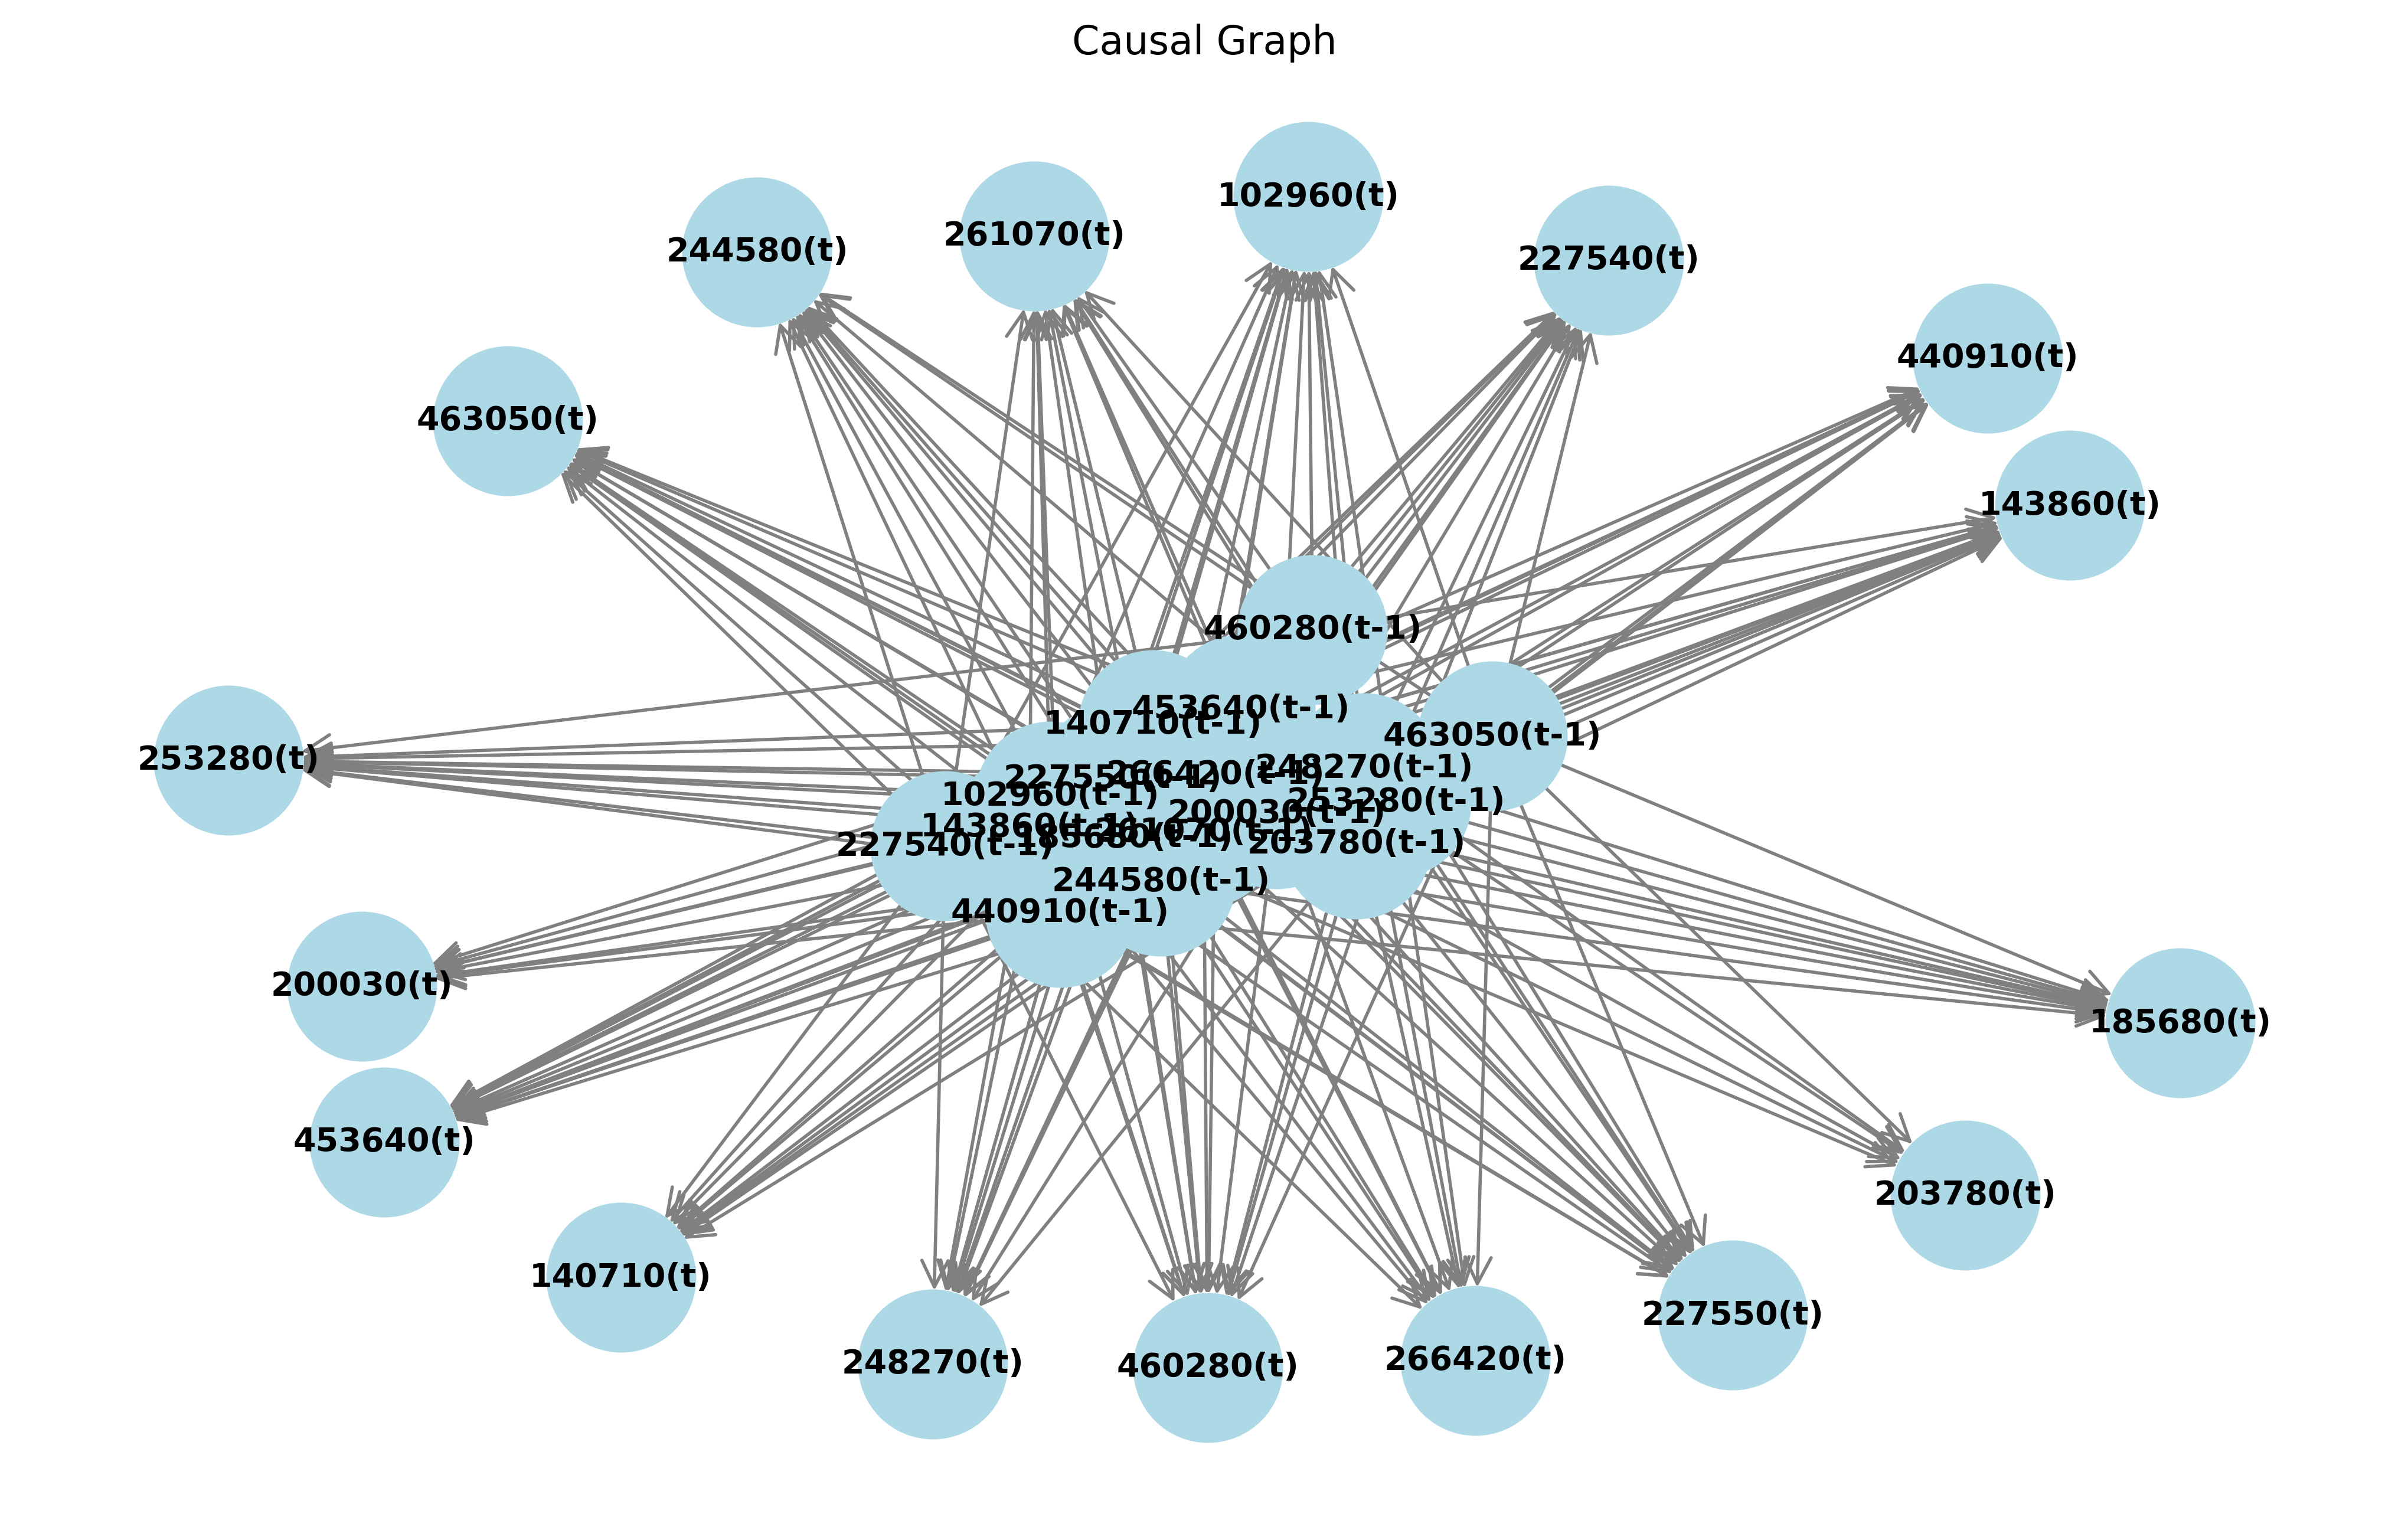

In [58]:
visualize_pyg_graph(data)

In [83]:
model = GAT(in_channels=1, hidden_channels=8, out_channels=1)

# X3(t)의 값을 평균으로 예측하도록 학습
target_node_name = '200030(t)'
target_node_idx = data.node_names.index(target_node_name)
target_value = data.x[target_node_idx].item()

train_gat(model, data, target_node_idx, target_value)

# 반사실 추론
model.eval()
factual, counterfactual = counterfactual_prediction(model, data, '440910(t-1)', 3.0)

/opt/miniconda3/envs/research/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch    0, Loss: 0.008087
Epoch  100, Loss: 0.000000
Epoch  200, Loss: 0.000000
Epoch  300, Loss: 0.000000
Epoch  400, Loss: 0.000000
Epoch  500, Loss: 0.000000
Epoch  600, Loss: 0.000000
Epoch  700, Loss: 0.000000
Epoch  800, Loss: 0.000000
Epoch  900, Loss: 0.000000


In [84]:
# 출력 텐서를 NumPy로 변환
factual_np = factual.detach().cpu().numpy().squeeze()
counterfactual_np = counterfactual.detach().cpu().numpy().squeeze()

# 데이터프레임 구성
summary_df = pd.DataFrame({
    'Node Index': list(range(len(data.node_names))),
    'Node Name': data.node_names,
    'Factual': factual_np,
    'Counterfactual': counterfactual_np,
    'Difference': counterfactual_np - factual_np
})

In [85]:
summary_df[summary_df['Difference'] > 0.01]

,Node Index,Node Name,Factual,Counterfactual,Difference
0,0,102960(t),0.158206,0.223384,0.065178
6,6,185680(t),0.152683,0.249077,0.096394
8,8,200030(t),0.178450,0.299629,0.121179
14,14,227550(t),0.167501,0.233251,0.065750
18,18,248270(t),0.174947,0.256991,0.082044
22,22,261070(t),0.154277,0.229081,0.074804
27,27,440910(t-1),0.086769,1.414600,1.327831
28,28,453640(t),0.178113,0.249078,0.070964
30,30,460280(t),0.171907,0.238023,0.066116
32,32,463050(t),0.178158,0.249077,0.070919
